### **Library Imports**

In [1]:
import os
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
from torchvision import transforms, datasets

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

### **Utilities and Constants**

In [2]:
def breaker(num: int=50, char: str="*") -> None:
    print("\n" + num*char + "\n")

    
def show_loss_graphs(L: list) -> None:
    TL, VL = [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
    x_Axis = np.arange(1, len(TL) + 1)
    plt.figure()
    plt.plot(x_Axis, TL, "r", label="Train")
    plt.plot(x_Axis, VL, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Loss Graph")
    plt.show()

    
def show_accuracy_graphs(A: list) -> None:
    TA, VA = [], []
    for i in range(len(A)):
        TA.append(A[i]["train"])
        VA.append(A[i]["valid"])
    x_Axis = np.arange(1, len(TA) + 1)
    plt.figure()
    plt.plot(x_Axis, TA, "r", label="Train")
    plt.plot(x_Axis, VA, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Accuracy Graph")
    plt.show()

    
def show_lr_graph(LR: list) -> None:
    x_Axis = [i+1 for i in range(len(LR))]
    plt.figure(figsize=(8, 6))
    plt.plot(x_Axis, LR, "rx")
    plt.grid()
    plt.show()

### **Configuration**

In [3]:
class CFG(object):
    def __init__(self, 
                 seed: int = 42,
                 size: int = 224,
                 n_splits: int = 5,
                 batch_size: int = 16,
                 epochs: int = 25,
                 early_stopping: int = 5,
                 lr: float = 1e-4,
                 wd: float = 0.0,
                 max_lr: float = 1e-3,
                 pct_start: float = 0.2,
                 steps_per_epoch: int = 100,
                 div_factor: int = 1e3, 
                 final_div_factor: float = 1e3,
                 ):
        self.seed = seed
        self.size = size
        self.n_splits = n_splits
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.lr = lr
        self.wd = wd
        self.max_lr = max_lr
        self.pct_start = pct_start
        self.steps_per_epoch = steps_per_epoch
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # self.train_transform = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize([0.1307,], [0.3081,]),
        #     transforms.RandomAffine(degrees=(-45, 45), translate=(0.15, 0.15), scale=(0.5, 1.5)),
        #     transforms.RandomHorizontalFlip(p=0.25),
        #     transforms.RandomVerticalFlip(p=0.25),
        # ])
        self.train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.1307,], [0.3081,]),
        ])
        self.valid_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.1307,], [0.3081,]),
        ])
                                
        self.save_path = "saves"
        if not os.path.exists(self.save_path): os.makedirs(self.save_path)
    
cfg = CFG(seed=42)

### **Dataset Template**

In [4]:
class DS(Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray = None, mode: str = "train", transform = None):

        assert re.match(r"^train$", mode, re.IGNORECASE) or re.match(r"^valid$", mode, re.IGNORECASE) or re.match(r"^test$", mode, re.IGNORECASE), "Invalid Mode"
        
        self.mode = mode
        self.images = images
        self.transform = transform

        if re.match(r"^train$", mode, re.IGNORECASE) or re.match(r"^valid$", mode, re.IGNORECASE):
            self.labels = labels

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        if re.match(r"^train$", self.mode, re.IGNORECASE) or re.match(r"^valid$", self.mode, re.IGNORECASE):
            return self.transform(self.images[idx]), torch.LongTensor(self.labels[idx])
        else:
            return self.transform(self.images[idx])

### **Model**

In [5]:
class Model(nn.Module):
    def __init__(self, filter_sizes: list=[64, 128, 256], HL: list=[1024], DP: float=0.25):
        
        super(Model, self).__init__()
        
        self.features = nn.Sequential()
        self.features.add_module("CN1", nn.Conv2d(in_channels=1, out_channels=filter_sizes[0], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.features.add_module("BN1", nn.BatchNorm2d(num_features=filter_sizes[0], eps=1e-5))
        self.features.add_module("AN1", nn.ReLU())
        self.features.add_module("MP1", nn.MaxPool2d(kernel_size=(2, 2)))
        self.features.add_module("CN2", nn.Conv2d(in_channels=filter_sizes[0], out_channels=filter_sizes[1], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.features.add_module("BN2", nn.BatchNorm2d(num_features=filter_sizes[1], eps=1e-5))
        self.features.add_module("AN2", nn.ReLU())
        self.features.add_module("MP2", nn.MaxPool2d(kernel_size=(2, 2)))
        self.features.add_module("CN3", nn.Conv2d(in_channels=filter_sizes[1], out_channels=filter_sizes[2], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.features.add_module("BN3", nn.BatchNorm2d(num_features=filter_sizes[2], eps=1e-5))
        self.features.add_module("AN3", nn.ReLU())
        self.features.add_module("MP3", nn.MaxPool2d(kernel_size=(2, 2)))    

        self.classifier = nn.Sequential()
        if len(HL) == 0:
            self.classifier.add_module("FC1", nn.Linear(in_features=filter_sizes[2]*3*3, out_features=10))
        elif len(HL) == 1:
            self.classifier.add_module("FC1", nn.Linear(in_features=filter_sizes[2]*3*3, out_features=HL[0]))
            if isinstance(DP, float):
                self.classifier.add_module("DP1", nn.Dropout(p=DP))
            self.classifier.add_module("AN1", nn.ReLU())
            self.classifier.add_module("FC2", nn.Linear(in_features=HL[0], out_features=10))
        elif len(HL) == 2:
            self.classifier.add_module("FC1", nn.Linear(in_features=filter_sizes[2]*3*3, out_features=HL[0]))
            if isinstance(DP, float):
                self.classifier.add_module("DP1", nn.Dropout(p=DP))
            self.classifier.add_module("AN1", nn.ReLU())
            self.classifier.add_module("FC2", nn.Linear(in_features=HL[0], out_features=HL[1]))
            if isinstance(DP, float):
                self.classifier.add_module("DP2", nn.Dropout(p=DP))
            self.classifier.add_module("AN2", nn.ReLU())
            self.classifier.add_module("FC3", nn.Linear(in_features=HL[1], out_features=10))
        
        self.classifier.add_module("Final Activation", nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x)

### **Fit and Predict Helpers**

In [6]:
def fit(model=None,
        optimizer=None, 
        scheduler_rlrop=None,
        scheduler_oclr=None,
        epochs=None, 
        early_stopping_patience=None, 
        dataloaders=None, 
        fold=None,
        seed=None,
        save_path=None,
        device=None,
        verbose=False) -> tuple:
    
    def get_accuracy(y_pred, y_true):
        y_pred = torch.argmax(y_pred, dim=1)
        return torch.count_nonzero(y_pred == y_true).item() / len(y_pred)
    
    if verbose:
        breaker()
        if fold: print(f"Training Fold {fold}...")
        else: print("Training ...")
        breaker()
        
    bestLoss: dict = {"train" : np.inf, "valid" : np.inf} 
    bestAccs: dict = {"train" : 0.0, "valid" : 0.0}
        
    Losses: list = []
    Accuracies: list = [] 
    LRs: list = []
        
    if fold: 
        ble_name = f"ble_state_fold_{fold}_seed_{seed}.pt"
        bae_name = f"bae_state_fold_{fold}_seed_{seed}.pt"
    else: 
        ble_name = f"ble_state_seed_{seed}.pt"
        bae_name = f"bae_state_seed_{seed}.pt"
    
    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss: dict = {"train" : 0.0, "valid" : 0.0} 
        epochAccs: dict = {"train" : 0.0, "valid" : 0.0}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass: list = []
            accsPerPass: list = []
                
            for X, y in dataloaders[phase]:
                X, y = X.to(device), y.to(device).view(-1)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = torch.nn.NLLLoss()(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        if scheduler_oclr: scheduler_oclr.step()
                lossPerPass.append(loss.item())
                accsPerPass.append(get_accuracy(output, y))
            epochLoss[phase] = np.mean(np.array(lossPerPass))
            epochAccs[phase] = np.mean(np.array(accsPerPass))
        if scheduler_oclr: LRs.append(scheduler_oclr.get_last_lr())
        Losses.append(epochLoss)
        Accuracies.append(epochAccs)
    
        if scheduler_oclr:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict(),
                         "scheduler_state_dict" : scheduler_oclr.state_dict()}
        
        elif scheduler_rlrop:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict(),
                         "scheduler_state_dict" : scheduler_rlrop.state_dict()}
        
        else:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict()}
        
        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save(save_dict, os.path.join(save_path, ble_name))
                torch.save(save_dict, os.path.join(save_path, bae_name))
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e + 1))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save(save_dict,os.path.join(save_path, ble_name))
        
        if epochAccs["valid"] > bestAccs["valid"]:
            bestAccs = epochAccs
            BAE = e + 1
            torch.save(save_dict,os.path.join(save_path, bae_name))
        
        if scheduler_rlrop: scheduler_rlrop.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} |\
 Train Accs: {:.5f} | Valid Accs: {:.5f} | Time: {:.2f} seconds".format(e+1, 
                                                                        epochLoss["train"], epochLoss["valid"], 
                                                                        epochAccs["train"], epochAccs["valid"], 
                                                                        time()-e_st))

    if verbose:                                           
        breaker()
        print(f"Best Validation Loss at Epoch {BLE}")
        breaker()
        print(f"Best Validation Accs at Epoch {BAE}")
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    
    return Losses, Accuracies, LRs, BLE, BAE, ble_name, bae_name


def predict_batch(model=None, dataloader=None, path=None, device=None) -> np.ndarray:
    model.load_state_dict(torch.load(path, map_location=device)["model_state_dict"])
    model.to(device)    
    model.eval()
    
    y_pred = torch.zeros(1, 1).to(device)
    
    for X, _ in dataloader:
        X = X.to(device)
        with torch.no_grad():
            output = torch.argmax(torch.exp(model(X)), dim=1)
        y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    
    return y_pred[1:].detach().cpu().numpy()

### **Load Data**

In [7]:
tr_data_setup = datasets.MNIST(
    root = "data",
    train = True,                         
    transform = cfg.train_transform, 
    download = True,            
)

ts_data_setup = datasets.MNIST(
    root = "data", 
    train = False, 
    download = True,
    transform = cfg.valid_transform,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### **Train**


**************************************************

 ----- Seed 0 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.34118 | Valid Loss: 0.05890 | Train Accs: 0.90965 | Valid Accs: 0.98250 | Time: 40.89 seconds
Epoch: 2 | Train Loss: 0.07908 | Valid Loss: 0.06252 | Train Accs: 0.97652 | Valid Accs: 0.97930 | Time: 33.30 seconds
Epoch: 3 | Train Loss: 0.05258 | Valid Loss: 0.06353 | Train Accs: 0.98443 | Valid Accs: 0.98360 | Time: 33.98 seconds
Epoch: 4 | Train Loss: 0.03871 | Valid Loss: 0.03135 | Train Accs: 0.98883 | Valid Accs: 0.99170 | Time: 33.85 seconds
Epoch: 5 | Train Loss: 0.02427 | Valid Loss: 0.03669 | Train Accs: 0.99323 | Valid Accs: 0.99060 | Time: 33.25 seconds
Epoch: 6 | Train Loss: 0.01605 | Valid Loss: 0.02745 | Train Accs: 0.99525 | Valid Accs: 0.99370 | Time: 34.49 seconds
Epoch: 7 | Train Loss: 0.00832 | Valid Loss: 0.02510 | Train Accs: 0.99767 | Valid Accs: 0.99

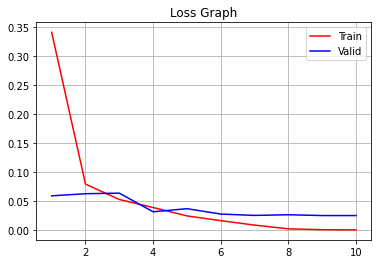


**************************************************



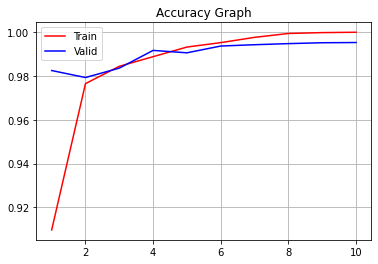


**************************************************



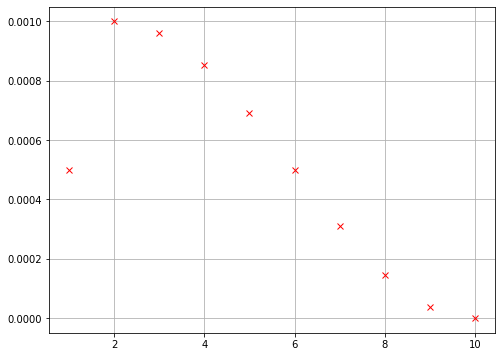


**************************************************


**************************************************

 ----- Seed 1 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.42116 | Valid Loss: 0.11835 | Train Accs: 0.88151 | Valid Accs: 0.96606 | Time: 20.43 seconds
Epoch: 2 | Train Loss: 0.06847 | Valid Loss: 0.07874 | Train Accs: 0.97958 | Valid Accs: 0.97402 | Time: 20.39 seconds
Epoch: 3 | Train Loss: 0.03943 | Valid Loss: 0.05649 | Train Accs: 0.98759 | Valid Accs: 0.98308 | Time: 21.09 seconds
Epoch: 4 | Train Loss: 0.02860 | Valid Loss: 0.03274 | Train Accs: 0.99105 | Valid Accs: 0.99045 | Time: 20.66 seconds
Epoch: 5 | Train Loss: 0.01932 | Valid Loss: 0.02423 | Train Accs: 0.99424 | Valid Accs: 0.99204 | Time: 21.08 seconds
Epoch: 6 | Train Loss: 0.01379 | Valid Loss: 0.02287 | Train Accs: 0.99582 | Valid Accs: 0.99293 | Time: 21.09 seconds
Epoch: 7 | Train Loss: 0.00532 | Valid L

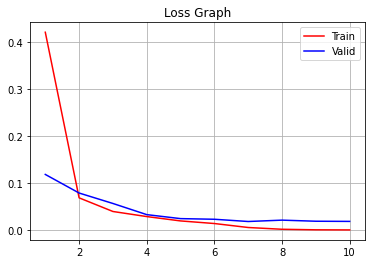


**************************************************



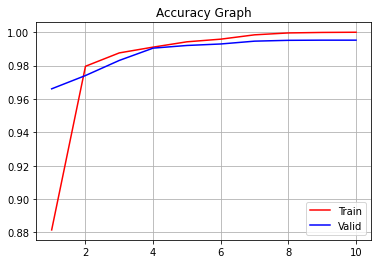


**************************************************



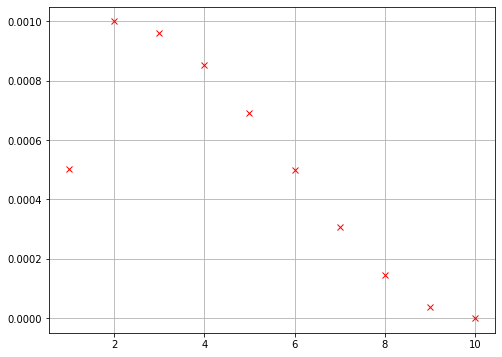


**************************************************


**************************************************

 ----- Seed 2 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.41991 | Valid Loss: 0.08207 | Train Accs: 0.88788 | Valid Accs: 0.97353 | Time: 21.25 seconds
Epoch: 2 | Train Loss: 0.06465 | Valid Loss: 0.03018 | Train Accs: 0.98034 | Valid Accs: 0.98985 | Time: 20.95 seconds
Epoch: 3 | Train Loss: 0.03879 | Valid Loss: 0.02808 | Train Accs: 0.98854 | Valid Accs: 0.99025 | Time: 20.67 seconds
Epoch: 4 | Train Loss: 0.02774 | Valid Loss: 0.03142 | Train Accs: 0.99147 | Valid Accs: 0.99055 | Time: 20.23 seconds
Epoch: 5 | Train Loss: 0.01776 | Valid Loss: 0.03112 | Train Accs: 0.99417 | Valid Accs: 0.99144 | Time: 20.18 seconds
Epoch: 6 | Train Loss: 0.01169 | Valid Loss: 0.02582 | Train Accs: 0.99629 | Valid Accs: 0.99293 | Time: 20.34 seconds
Epoch: 7 | Train Loss: 0.00571 | Valid L

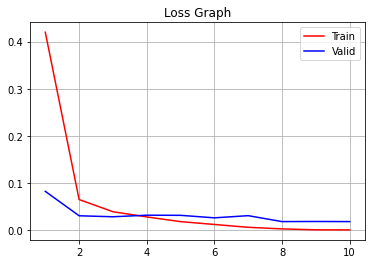


**************************************************



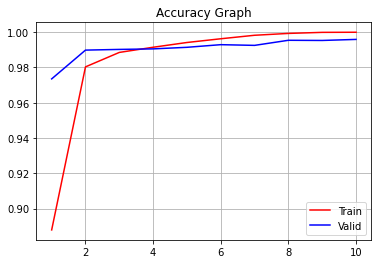


**************************************************



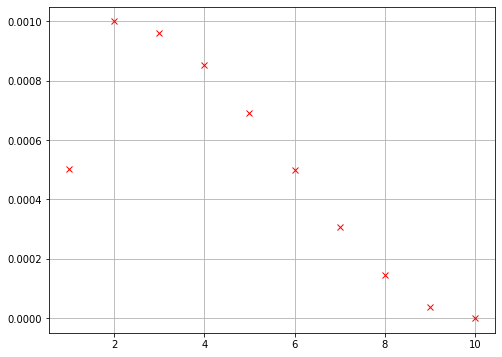


**************************************************


**************************************************

 ----- Seed 3 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.42015 | Valid Loss: 0.11300 | Train Accs: 0.88589 | Valid Accs: 0.96507 | Time: 21.02 seconds
Epoch: 2 | Train Loss: 0.06605 | Valid Loss: 0.04742 | Train Accs: 0.98013 | Valid Accs: 0.98388 | Time: 20.74 seconds
Epoch: 3 | Train Loss: 0.03935 | Valid Loss: 0.02783 | Train Accs: 0.98789 | Valid Accs: 0.99154 | Time: 21.08 seconds
Epoch: 4 | Train Loss: 0.02707 | Valid Loss: 0.03857 | Train Accs: 0.99175 | Valid Accs: 0.98875 | Time: 19.31 seconds
Epoch: 5 | Train Loss: 0.01919 | Valid Loss: 0.02476 | Train Accs: 0.99422 | Valid Accs: 0.99273 | Time: 21.23 seconds
Epoch: 6 | Train Loss: 0.01306 | Valid Loss: 0.02105 | Train Accs: 0.99580 | Valid Accs: 0.99403 | Time: 21.30 seconds
Epoch: 7 | Train Loss: 0.00513 | Valid L

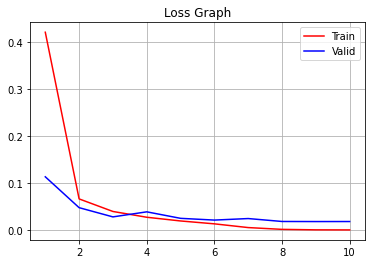


**************************************************



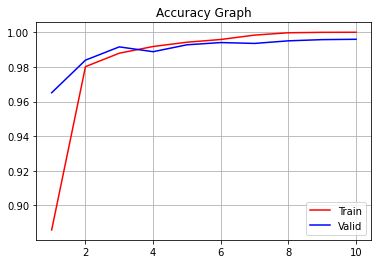


**************************************************



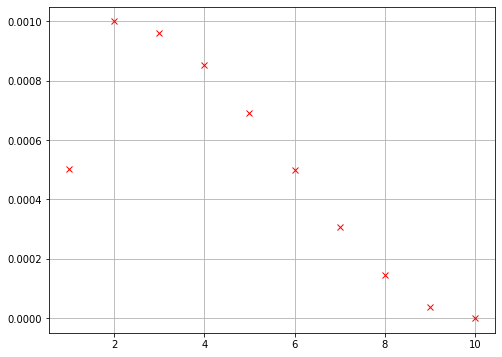


**************************************************


**************************************************

 ----- Seed 4 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.42004 | Valid Loss: 0.07737 | Train Accs: 0.88754 | Valid Accs: 0.97771 | Time: 20.58 seconds
Epoch: 2 | Train Loss: 0.06943 | Valid Loss: 0.07575 | Train Accs: 0.97916 | Valid Accs: 0.97552 | Time: 20.33 seconds
Epoch: 3 | Train Loss: 0.04061 | Valid Loss: 0.03875 | Train Accs: 0.98736 | Valid Accs: 0.98726 | Time: 20.62 seconds
Epoch: 4 | Train Loss: 0.02829 | Valid Loss: 0.03501 | Train Accs: 0.99120 | Valid Accs: 0.98915 | Time: 20.89 seconds
Epoch: 5 | Train Loss: 0.02091 | Valid Loss: 0.02342 | Train Accs: 0.99352 | Valid Accs: 0.99283 | Time: 20.90 seconds
Epoch: 6 | Train Loss: 0.01319 | Valid Loss: 0.02227 | Train Accs: 0.99570 | Valid Accs: 0.99363 | Time: 20.70 seconds
Epoch: 7 | Train Loss: 0.00674 | Valid L

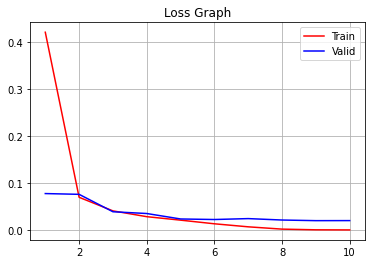


**************************************************



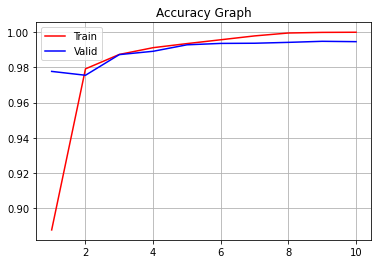


**************************************************



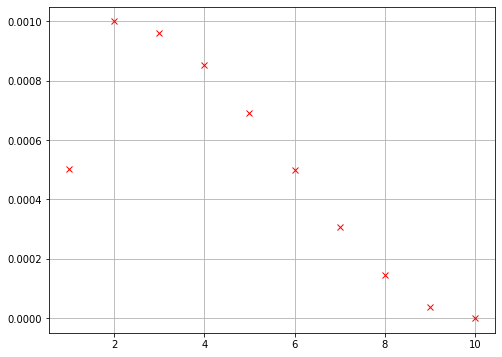


**************************************************


**************************************************

 ----- Seed 5 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.41720 | Valid Loss: 0.12870 | Train Accs: 0.88634 | Valid Accs: 0.96079 | Time: 20.24 seconds
Epoch: 2 | Train Loss: 0.06733 | Valid Loss: 0.05068 | Train Accs: 0.97973 | Valid Accs: 0.98348 | Time: 20.94 seconds
Epoch: 3 | Train Loss: 0.03945 | Valid Loss: 0.04654 | Train Accs: 0.98817 | Valid Accs: 0.98557 | Time: 21.02 seconds
Epoch: 4 | Train Loss: 0.02730 | Valid Loss: 0.04092 | Train Accs: 0.99159 | Valid Accs: 0.98846 | Time: 20.57 seconds
Epoch: 5 | Train Loss: 0.01989 | Valid Loss: 0.02474 | Train Accs: 0.99365 | Valid Accs: 0.99204 | Time: 21.06 seconds
Epoch: 6 | Train Loss: 0.01258 | Valid Loss: 0.03187 | Train Accs: 0.99619 | Valid Accs: 0.99124 | Time: 19.40 seconds
Epoch: 7 | Train Loss: 0.00550 | Valid L

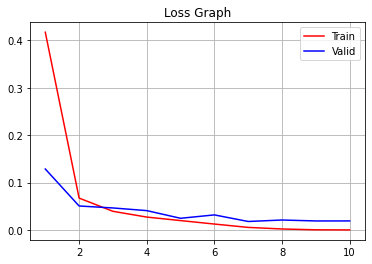


**************************************************



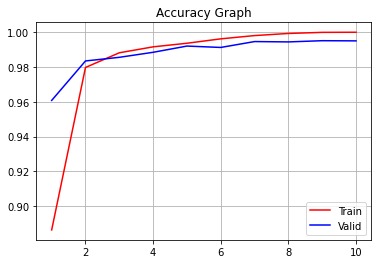


**************************************************



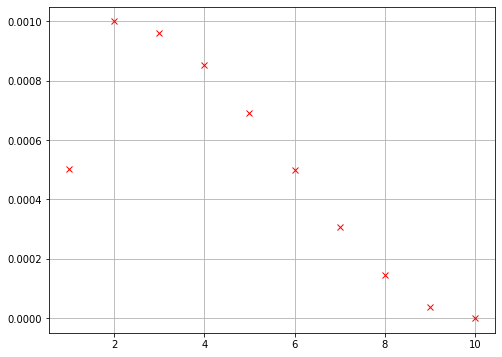


**************************************************


**************************************************

 ----- Seed 6 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.42193 | Valid Loss: 0.08050 | Train Accs: 0.88258 | Valid Accs: 0.97393 | Time: 21.18 seconds
Epoch: 2 | Train Loss: 0.06724 | Valid Loss: 0.03677 | Train Accs: 0.97933 | Valid Accs: 0.98726 | Time: 21.15 seconds
Epoch: 3 | Train Loss: 0.03908 | Valid Loss: 0.02509 | Train Accs: 0.98787 | Valid Accs: 0.99204 | Time: 20.44 seconds
Epoch: 4 | Train Loss: 0.02828 | Valid Loss: 0.02722 | Train Accs: 0.99137 | Valid Accs: 0.99154 | Time: 19.74 seconds
Epoch: 5 | Train Loss: 0.02053 | Valid Loss: 0.03019 | Train Accs: 0.99349 | Valid Accs: 0.99074 | Time: 19.20 seconds
Epoch: 6 | Train Loss: 0.01256 | Valid Loss: 0.02355 | Train Accs: 0.99605 | Valid Accs: 0.99264 | Time: 21.02 seconds
Epoch: 7 | Train Loss: 0.00570 | Valid L

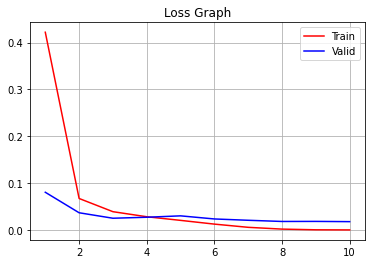


**************************************************



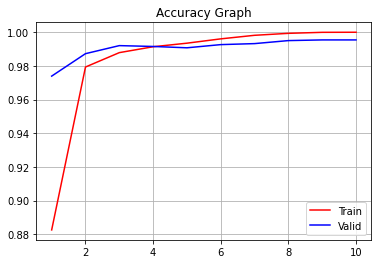


**************************************************



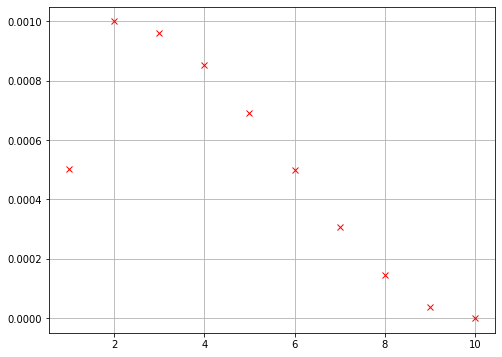


**************************************************


**************************************************

 ----- Seed 7 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.42848 | Valid Loss: 0.12044 | Train Accs: 0.88348 | Valid Accs: 0.96407 | Time: 20.37 seconds
Epoch: 2 | Train Loss: 0.06717 | Valid Loss: 0.07551 | Train Accs: 0.97964 | Valid Accs: 0.97522 | Time: 20.98 seconds
Epoch: 3 | Train Loss: 0.03910 | Valid Loss: 0.03812 | Train Accs: 0.98812 | Valid Accs: 0.98816 | Time: 21.54 seconds
Epoch: 4 | Train Loss: 0.02871 | Valid Loss: 0.04569 | Train Accs: 0.99100 | Valid Accs: 0.98507 | Time: 19.42 seconds
Epoch: 5 | Train Loss: 0.01960 | Valid Loss: 0.02979 | Train Accs: 0.99367 | Valid Accs: 0.99114 | Time: 20.85 seconds
Epoch: 6 | Train Loss: 0.01143 | Valid Loss: 0.03022 | Train Accs: 0.99627 | Valid Accs: 0.99204 | Time: 20.07 seconds
Epoch: 7 | Train Loss: 0.00622 | Valid L

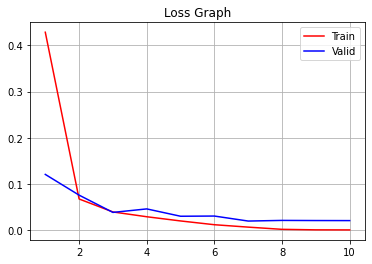


**************************************************



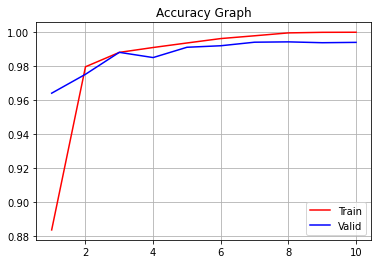


**************************************************



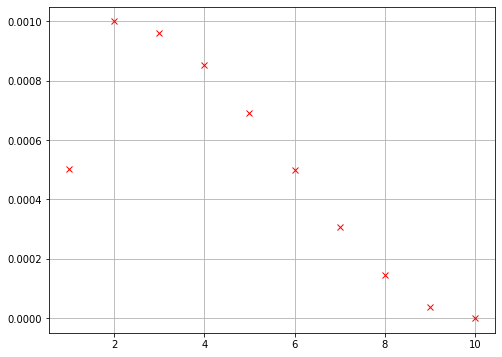


**************************************************


**************************************************

 ----- Seed 8 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.43071 | Valid Loss: 0.20510 | Train Accs: 0.88005 | Valid Accs: 0.93621 | Time: 20.67 seconds
Epoch: 2 | Train Loss: 0.06756 | Valid Loss: 0.03608 | Train Accs: 0.97961 | Valid Accs: 0.98885 | Time: 21.12 seconds
Epoch: 3 | Train Loss: 0.03832 | Valid Loss: 0.03767 | Train Accs: 0.98811 | Valid Accs: 0.98806 | Time: 19.56 seconds
Epoch: 4 | Train Loss: 0.02754 | Valid Loss: 0.03143 | Train Accs: 0.99124 | Valid Accs: 0.99134 | Time: 20.91 seconds
Epoch: 5 | Train Loss: 0.01774 | Valid Loss: 0.03172 | Train Accs: 0.99440 | Valid Accs: 0.99154 | Time: 19.55 seconds
Epoch: 6 | Train Loss: 0.01167 | Valid Loss: 0.03553 | Train Accs: 0.99640 | Valid Accs: 0.99164 | Time: 20.13 seconds
Epoch: 7 | Train Loss: 0.00749 | Valid L

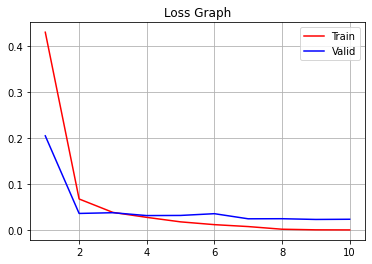


**************************************************



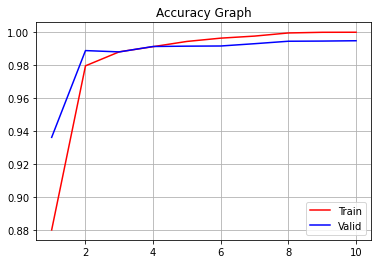


**************************************************



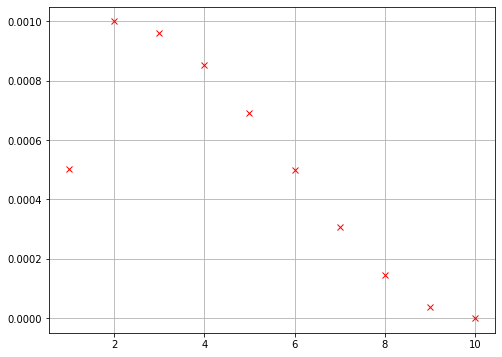


**************************************************


**************************************************

 ----- Seed 9 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.42810 | Valid Loss: 0.10446 | Train Accs: 0.88266 | Valid Accs: 0.97004 | Time: 19.95 seconds
Epoch: 2 | Train Loss: 0.06881 | Valid Loss: 0.04295 | Train Accs: 0.97901 | Valid Accs: 0.98537 | Time: 20.65 seconds
Epoch: 3 | Train Loss: 0.04232 | Valid Loss: 0.03271 | Train Accs: 0.98644 | Valid Accs: 0.99064 | Time: 21.14 seconds
Epoch: 4 | Train Loss: 0.02940 | Valid Loss: 0.04071 | Train Accs: 0.99107 | Valid Accs: 0.98726 | Time: 19.14 seconds
Epoch: 5 | Train Loss: 0.02233 | Valid Loss: 0.02146 | Train Accs: 0.99305 | Valid Accs: 0.99383 | Time: 20.61 seconds
Epoch: 6 | Train Loss: 0.01182 | Valid Loss: 0.02214 | Train Accs: 0.99632 | Valid Accs: 0.99293 | Time: 19.29 seconds
Epoch: 7 | Train Loss: 0.00658 | Valid L

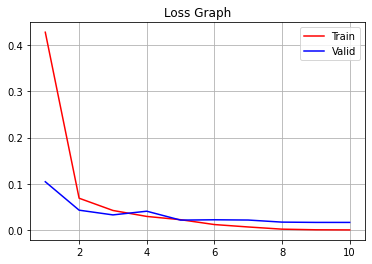


**************************************************



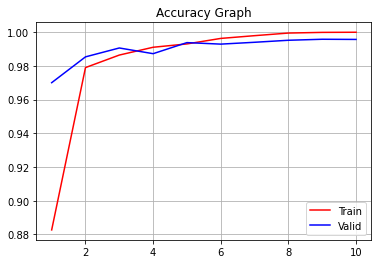


**************************************************



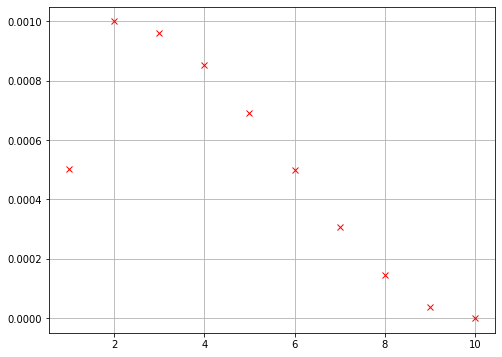


**************************************************


**************************************************

 ----- Seed 10 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.42812 | Valid Loss: 0.04444 | Train Accs: 0.88233 | Valid Accs: 0.98477 | Time: 20.60 seconds
Epoch: 2 | Train Loss: 0.07046 | Valid Loss: 0.03221 | Train Accs: 0.97824 | Valid Accs: 0.98985 | Time: 20.68 seconds
Epoch: 3 | Train Loss: 0.03940 | Valid Loss: 0.03278 | Train Accs: 0.98789 | Valid Accs: 0.98935 | Time: 19.88 seconds
Epoch: 4 | Train Loss: 0.02728 | Valid Loss: 0.03688 | Train Accs: 0.99145 | Valid Accs: 0.98995 | Time: 19.64 seconds
Epoch: 5 | Train Loss: 0.01934 | Valid Loss: 0.03391 | Train Accs: 0.99422 | Valid Accs: 0.99005 | Time: 19.86 seconds
Epoch: 6 | Train Loss: 0.01199 | Valid Loss: 0.03164 | Train Accs: 0.99612 | Valid Accs: 0.99134 | Time: 20.79 seconds
Epoch: 7 | Train Loss: 0.00554 | Valid 

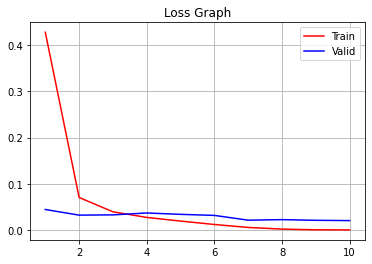


**************************************************



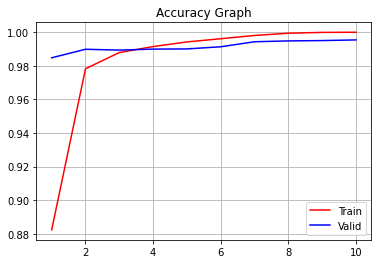


**************************************************



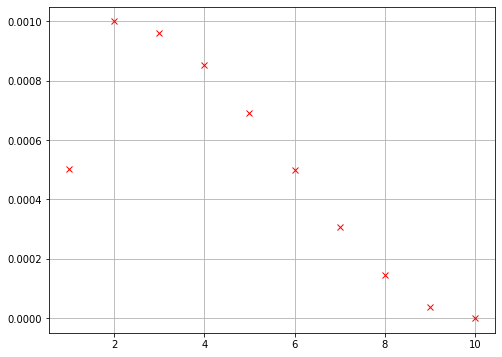


**************************************************


**************************************************

 ----- Seed 11 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.42305 | Valid Loss: 0.08962 | Train Accs: 0.88263 | Valid Accs: 0.97373 | Time: 20.41 seconds
Epoch: 2 | Train Loss: 0.06783 | Valid Loss: 0.03763 | Train Accs: 0.97899 | Valid Accs: 0.98706 | Time: 21.04 seconds
Epoch: 3 | Train Loss: 0.03795 | Valid Loss: 0.02856 | Train Accs: 0.98857 | Valid Accs: 0.99055 | Time: 20.50 seconds
Epoch: 4 | Train Loss: 0.02658 | Valid Loss: 0.04066 | Train Accs: 0.99174 | Valid Accs: 0.98676 | Time: 20.00 seconds
Epoch: 5 | Train Loss: 0.02031 | Valid Loss: 0.04073 | Train Accs: 0.99385 | Valid Accs: 0.98826 | Time: 19.52 seconds
Epoch: 6 | Train Loss: 0.01217 | Valid Loss: 0.03331 | Train Accs: 0.99622 | Valid Accs: 0.99164 | Time: 19.56 seconds
Epoch: 7 | Train Loss: 0.00641 | Valid 

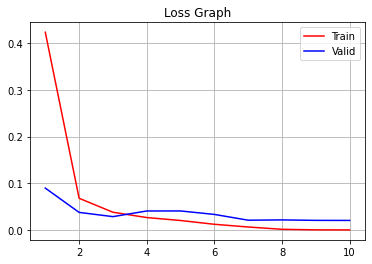


**************************************************



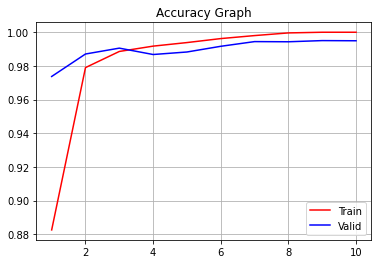


**************************************************



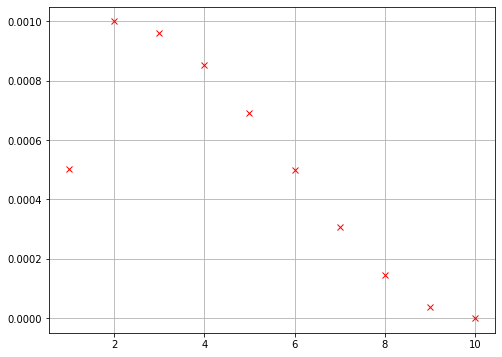


**************************************************


**************************************************

 ----- Seed 12 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.42806 | Valid Loss: 0.07434 | Train Accs: 0.88001 | Valid Accs: 0.97781 | Time: 20.63 seconds
Epoch: 2 | Train Loss: 0.06589 | Valid Loss: 0.06372 | Train Accs: 0.98033 | Valid Accs: 0.97920 | Time: 20.30 seconds
Epoch: 3 | Train Loss: 0.03969 | Valid Loss: 0.03670 | Train Accs: 0.98794 | Valid Accs: 0.98915 | Time: 21.59 seconds
Epoch: 4 | Train Loss: 0.02930 | Valid Loss: 0.02334 | Train Accs: 0.99092 | Valid Accs: 0.99214 | Time: 20.55 seconds
Epoch: 5 | Train Loss: 0.02071 | Valid Loss: 0.02894 | Train Accs: 0.99359 | Valid Accs: 0.99194 | Time: 18.99 seconds
Epoch: 6 | Train Loss: 0.01280 | Valid Loss: 0.02700 | Train Accs: 0.99607 | Valid Accs: 0.99104 | Time: 19.35 seconds
Epoch: 7 | Train Loss: 0.00617 | Valid 

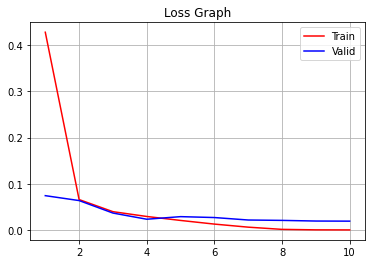


**************************************************



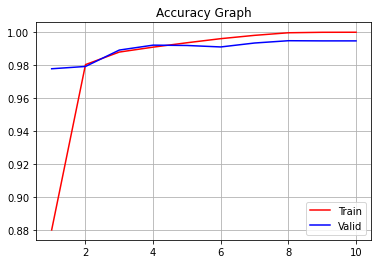


**************************************************



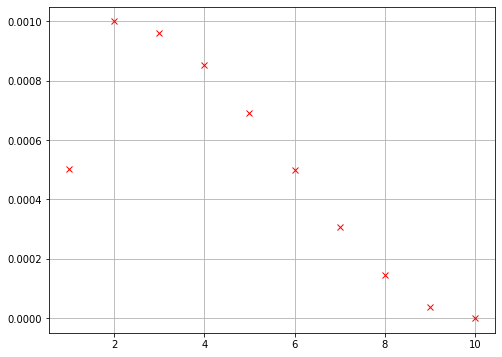


**************************************************


**************************************************

 ----- Seed 13 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.41805 | Valid Loss: 0.10535 | Train Accs: 0.88834 | Valid Accs: 0.96576 | Time: 20.13 seconds
Epoch: 2 | Train Loss: 0.06965 | Valid Loss: 0.05075 | Train Accs: 0.97953 | Valid Accs: 0.98627 | Time: 20.59 seconds
Epoch: 3 | Train Loss: 0.03984 | Valid Loss: 0.04484 | Train Accs: 0.98782 | Valid Accs: 0.98696 | Time: 20.29 seconds
Epoch: 4 | Train Loss: 0.02771 | Valid Loss: 0.02867 | Train Accs: 0.99129 | Valid Accs: 0.99074 | Time: 20.68 seconds
Epoch: 5 | Train Loss: 0.01990 | Valid Loss: 0.02575 | Train Accs: 0.99382 | Valid Accs: 0.99174 | Time: 20.69 seconds
Epoch: 6 | Train Loss: 0.01221 | Valid Loss: 0.02246 | Train Accs: 0.99615 | Valid Accs: 0.99313 | Time: 20.40 seconds
Epoch: 7 | Train Loss: 0.00622 | Valid 

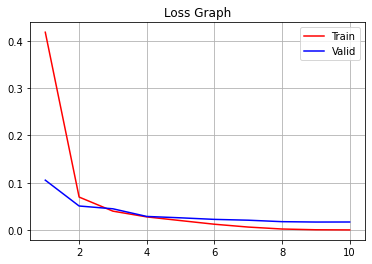


**************************************************



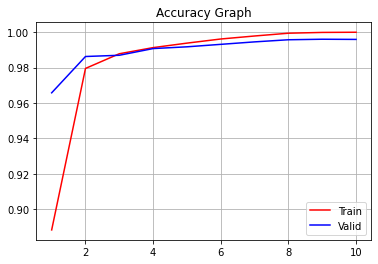


**************************************************



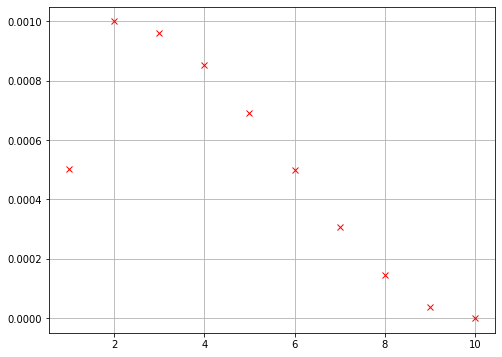


**************************************************


**************************************************

 ----- Seed 14 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.42040 | Valid Loss: 0.06460 | Train Accs: 0.88511 | Valid Accs: 0.98099 | Time: 20.75 seconds
Epoch: 2 | Train Loss: 0.06760 | Valid Loss: 0.07696 | Train Accs: 0.97944 | Valid Accs: 0.97701 | Time: 19.42 seconds
Epoch: 3 | Train Loss: 0.03894 | Valid Loss: 0.07673 | Train Accs: 0.98824 | Valid Accs: 0.97621 | Time: 19.78 seconds
Epoch: 4 | Train Loss: 0.02836 | Valid Loss: 0.03166 | Train Accs: 0.99142 | Valid Accs: 0.99015 | Time: 21.11 seconds
Epoch: 5 | Train Loss: 0.01906 | Valid Loss: 0.02306 | Train Accs: 0.99399 | Valid Accs: 0.99333 | Time: 20.80 seconds
Epoch: 6 | Train Loss: 0.01203 | Valid Loss: 0.02484 | Train Accs: 0.99594 | Valid Accs: 0.99273 | Time: 19.29 seconds
Epoch: 7 | Train Loss: 0.00691 | Valid 

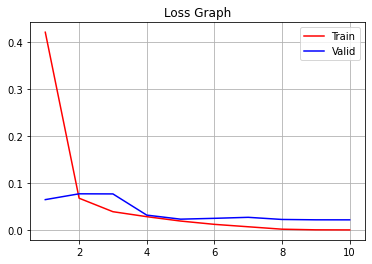


**************************************************



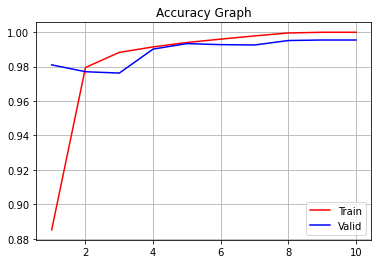


**************************************************



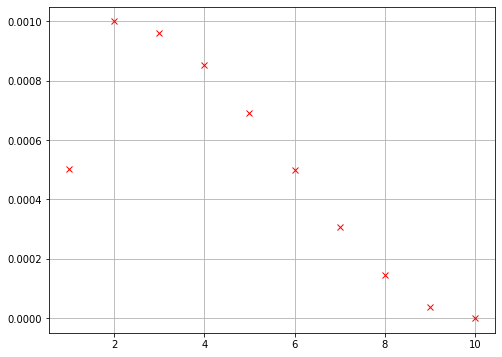


**************************************************


**************************************************

 ----- Seed 15 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.40838 | Valid Loss: 0.13924 | Train Accs: 0.89329 | Valid Accs: 0.96148 | Time: 20.48 seconds
Epoch: 2 | Train Loss: 0.06924 | Valid Loss: 0.09892 | Train Accs: 0.97791 | Valid Accs: 0.97054 | Time: 20.58 seconds
Epoch: 3 | Train Loss: 0.03841 | Valid Loss: 0.03570 | Train Accs: 0.98861 | Valid Accs: 0.98846 | Time: 20.15 seconds
Epoch: 4 | Train Loss: 0.02962 | Valid Loss: 0.02822 | Train Accs: 0.99049 | Valid Accs: 0.99084 | Time: 21.03 seconds
Epoch: 5 | Train Loss: 0.01935 | Valid Loss: 0.02607 | Train Accs: 0.99412 | Valid Accs: 0.99264 | Time: 20.21 seconds
Epoch: 6 | Train Loss: 0.01332 | Valid Loss: 0.02119 | Train Accs: 0.99549 | Valid Accs: 0.99343 | Time: 20.48 seconds
Epoch: 7 | Train Loss: 0.00541 | Valid 

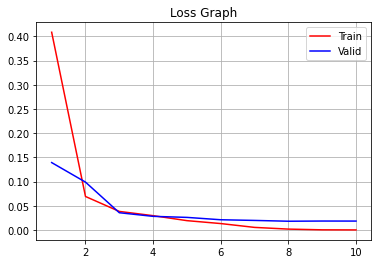


**************************************************



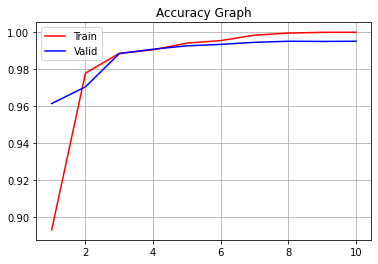


**************************************************



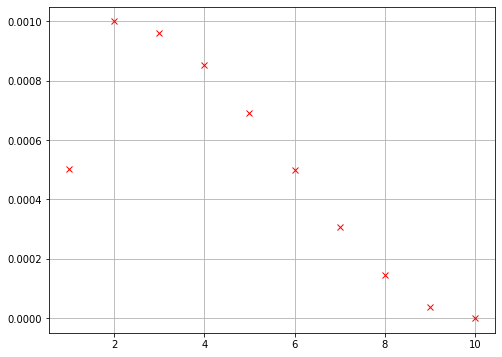


**************************************************


**************************************************

 ----- Seed 16 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.42389 | Valid Loss: 0.10360 | Train Accs: 0.88408 | Valid Accs: 0.96835 | Time: 20.55 seconds
Epoch: 2 | Train Loss: 0.06614 | Valid Loss: 0.06759 | Train Accs: 0.97936 | Valid Accs: 0.97920 | Time: 21.28 seconds
Epoch: 3 | Train Loss: 0.04070 | Valid Loss: 0.03441 | Train Accs: 0.98774 | Valid Accs: 0.98846 | Time: 21.17 seconds
Epoch: 4 | Train Loss: 0.02715 | Valid Loss: 0.03383 | Train Accs: 0.99175 | Valid Accs: 0.98945 | Time: 20.45 seconds
Epoch: 5 | Train Loss: 0.02050 | Valid Loss: 0.03352 | Train Accs: 0.99380 | Valid Accs: 0.99104 | Time: 21.74 seconds
Epoch: 6 | Train Loss: 0.01313 | Valid Loss: 0.02734 | Train Accs: 0.99599 | Valid Accs: 0.99273 | Time: 20.77 seconds
Epoch: 7 | Train Loss: 0.00503 | Valid 

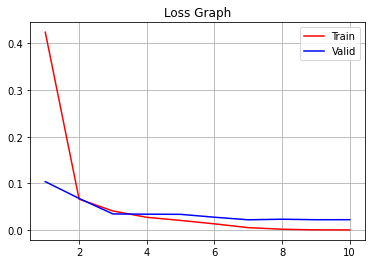


**************************************************



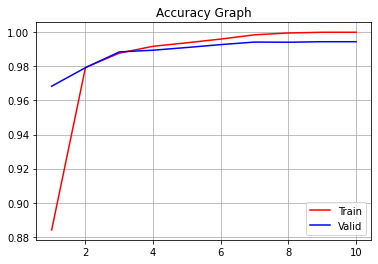


**************************************************



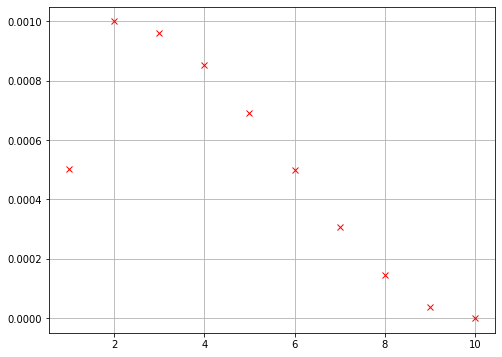


**************************************************


**************************************************

 ----- Seed 17 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.42531 | Valid Loss: 0.09539 | Train Accs: 0.88385 | Valid Accs: 0.97203 | Time: 20.47 seconds
Epoch: 2 | Train Loss: 0.06678 | Valid Loss: 0.03884 | Train Accs: 0.98044 | Valid Accs: 0.98746 | Time: 20.97 seconds
Epoch: 3 | Train Loss: 0.03983 | Valid Loss: 0.03884 | Train Accs: 0.98779 | Valid Accs: 0.98816 | Time: 21.63 seconds
Epoch: 4 | Train Loss: 0.02741 | Valid Loss: 0.05118 | Train Accs: 0.99169 | Valid Accs: 0.98527 | Time: 19.81 seconds
Epoch: 5 | Train Loss: 0.01849 | Valid Loss: 0.03157 | Train Accs: 0.99427 | Valid Accs: 0.99214 | Time: 20.49 seconds
Epoch: 6 | Train Loss: 0.01178 | Valid Loss: 0.02238 | Train Accs: 0.99645 | Valid Accs: 0.99343 | Time: 21.19 seconds
Epoch: 7 | Train Loss: 0.00605 | Valid 

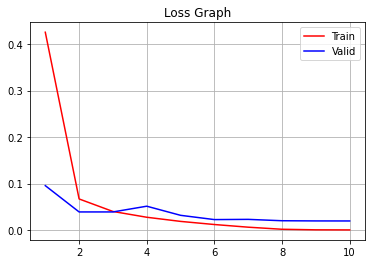


**************************************************



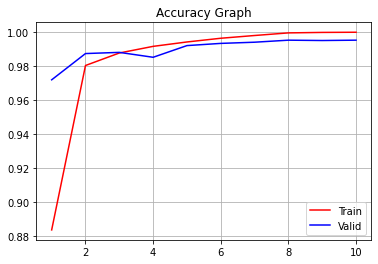


**************************************************



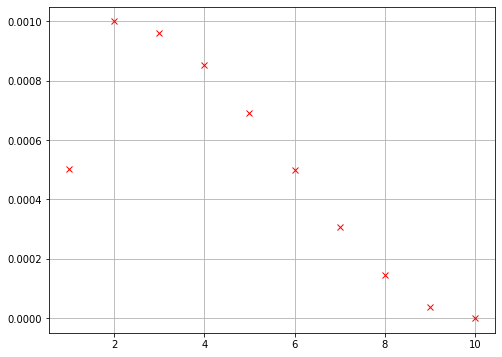


**************************************************


**************************************************

 ----- Seed 18 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.42089 | Valid Loss: 0.05140 | Train Accs: 0.88564 | Valid Accs: 0.98179 | Time: 20.68 seconds
Epoch: 2 | Train Loss: 0.06975 | Valid Loss: 0.05627 | Train Accs: 0.97858 | Valid Accs: 0.98129 | Time: 19.89 seconds
Epoch: 3 | Train Loss: 0.03863 | Valid Loss: 0.02452 | Train Accs: 0.98797 | Valid Accs: 0.99254 | Time: 21.50 seconds
Epoch: 4 | Train Loss: 0.02735 | Valid Loss: 0.02935 | Train Accs: 0.99150 | Valid Accs: 0.98995 | Time: 19.40 seconds
Epoch: 5 | Train Loss: 0.02038 | Valid Loss: 0.03863 | Train Accs: 0.99359 | Valid Accs: 0.98925 | Time: 19.97 seconds
Epoch: 6 | Train Loss: 0.01361 | Valid Loss: 0.02040 | Train Accs: 0.99567 | Valid Accs: 0.99323 | Time: 21.18 seconds
Epoch: 7 | Train Loss: 0.00636 | Valid 

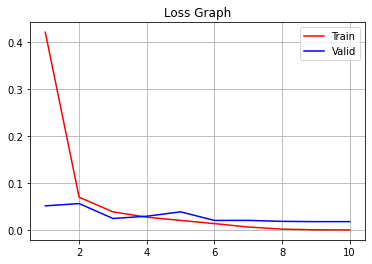


**************************************************



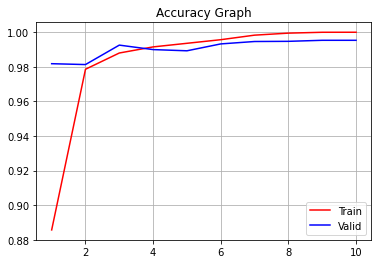


**************************************************



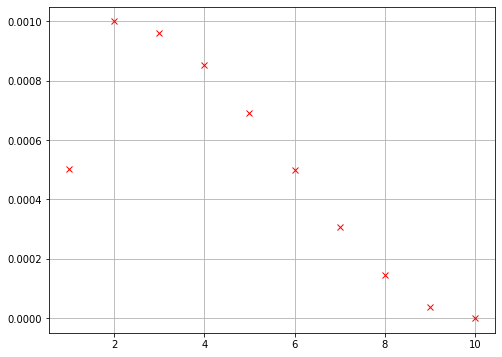


**************************************************


**************************************************

 ----- Seed 19 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.41891 | Valid Loss: 0.17631 | Train Accs: 0.88509 | Valid Accs: 0.94138 | Time: 21.17 seconds
Epoch: 2 | Train Loss: 0.06917 | Valid Loss: 0.03132 | Train Accs: 0.97906 | Valid Accs: 0.98885 | Time: 21.31 seconds
Epoch: 3 | Train Loss: 0.03886 | Valid Loss: 0.04618 | Train Accs: 0.98787 | Valid Accs: 0.98646 | Time: 19.60 seconds
Epoch: 4 | Train Loss: 0.02641 | Valid Loss: 0.03157 | Train Accs: 0.99195 | Valid Accs: 0.99074 | Time: 20.36 seconds
Epoch: 5 | Train Loss: 0.02091 | Valid Loss: 0.02985 | Train Accs: 0.99352 | Valid Accs: 0.99074 | Time: 20.84 seconds
Epoch: 6 | Train Loss: 0.01153 | Valid Loss: 0.03310 | Train Accs: 0.99615 | Valid Accs: 0.99064 | Time: 19.50 seconds
Epoch: 7 | Train Loss: 0.00579 | Valid 

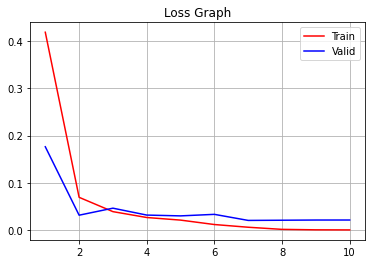


**************************************************



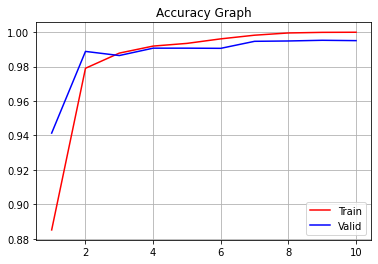


**************************************************



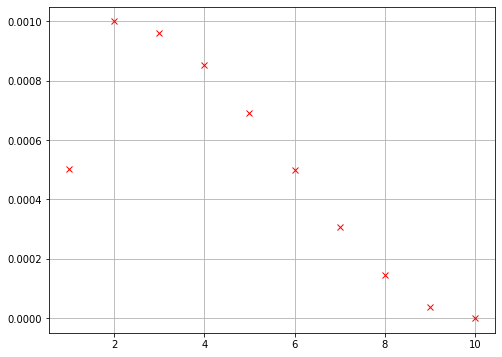


**************************************************


**************************************************

 ----- Seed 20 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.42548 | Valid Loss: 0.06341 | Train Accs: 0.88335 | Valid Accs: 0.98089 | Time: 20.54 seconds
Epoch: 2 | Train Loss: 0.07138 | Valid Loss: 0.05694 | Train Accs: 0.97824 | Valid Accs: 0.98298 | Time: 21.29 seconds
Epoch: 3 | Train Loss: 0.04051 | Valid Loss: 0.03903 | Train Accs: 0.98719 | Valid Accs: 0.98786 | Time: 21.34 seconds
Epoch: 4 | Train Loss: 0.02664 | Valid Loss: 0.03997 | Train Accs: 0.99154 | Valid Accs: 0.98915 | Time: 19.87 seconds
Epoch: 5 | Train Loss: 0.02108 | Valid Loss: 0.03123 | Train Accs: 0.99352 | Valid Accs: 0.98955 | Time: 21.32 seconds
Epoch: 6 | Train Loss: 0.01203 | Valid Loss: 0.02667 | Train Accs: 0.99650 | Valid Accs: 0.99144 | Time: 21.00 seconds
Epoch: 7 | Train Loss: 0.00619 | Valid 

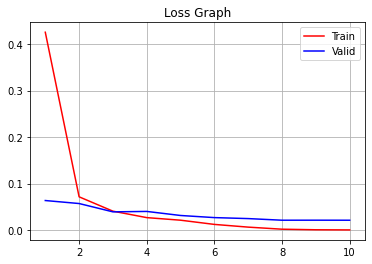


**************************************************



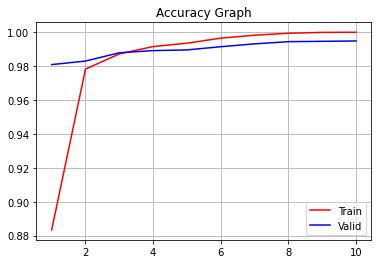


**************************************************



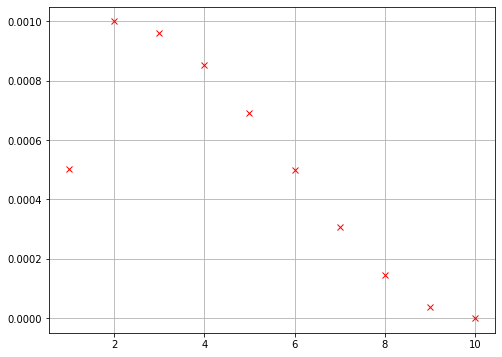


**************************************************


**************************************************

 ----- Seed 21 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.41644 | Valid Loss: 0.11645 | Train Accs: 0.88799 | Valid Accs: 0.96338 | Time: 20.92 seconds
Epoch: 2 | Train Loss: 0.06915 | Valid Loss: 0.04101 | Train Accs: 0.97881 | Valid Accs: 0.98736 | Time: 20.93 seconds
Epoch: 3 | Train Loss: 0.04037 | Valid Loss: 0.03028 | Train Accs: 0.98804 | Valid Accs: 0.99114 | Time: 20.71 seconds
Epoch: 4 | Train Loss: 0.02919 | Valid Loss: 0.02864 | Train Accs: 0.99117 | Valid Accs: 0.99144 | Time: 21.18 seconds
Epoch: 5 | Train Loss: 0.01988 | Valid Loss: 0.04268 | Train Accs: 0.99389 | Valid Accs: 0.98855 | Time: 20.10 seconds
Epoch: 6 | Train Loss: 0.01344 | Valid Loss: 0.02389 | Train Accs: 0.99614 | Valid Accs: 0.99303 | Time: 20.70 seconds
Epoch: 7 | Train Loss: 0.00577 | Valid 

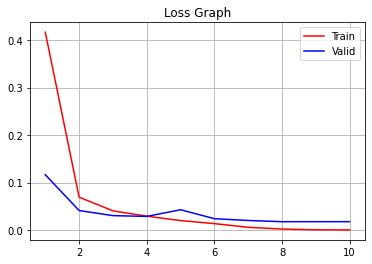


**************************************************



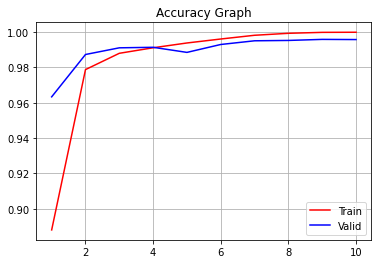


**************************************************



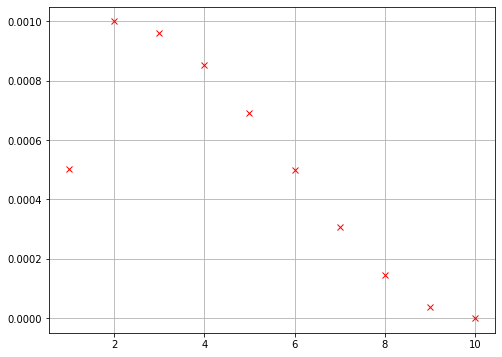


**************************************************


**************************************************

 ----- Seed 22 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.42324 | Valid Loss: 0.13021 | Train Accs: 0.88513 | Valid Accs: 0.95770 | Time: 20.90 seconds
Epoch: 2 | Train Loss: 0.06965 | Valid Loss: 0.06025 | Train Accs: 0.97874 | Valid Accs: 0.98129 | Time: 20.70 seconds
Epoch: 3 | Train Loss: 0.03952 | Valid Loss: 0.02755 | Train Accs: 0.98806 | Valid Accs: 0.99104 | Time: 21.19 seconds
Epoch: 4 | Train Loss: 0.02965 | Valid Loss: 0.03199 | Train Accs: 0.99052 | Valid Accs: 0.98945 | Time: 19.41 seconds
Epoch: 5 | Train Loss: 0.02033 | Valid Loss: 0.05093 | Train Accs: 0.99384 | Valid Accs: 0.98258 | Time: 19.48 seconds
Epoch: 6 | Train Loss: 0.01272 | Valid Loss: 0.02597 | Train Accs: 0.99610 | Valid Accs: 0.99214 | Time: 20.96 seconds
Epoch: 7 | Train Loss: 0.00631 | Valid 

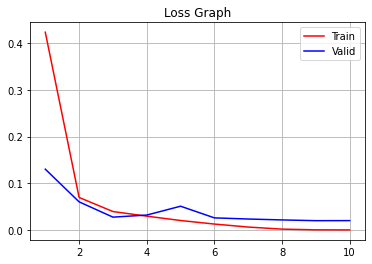


**************************************************



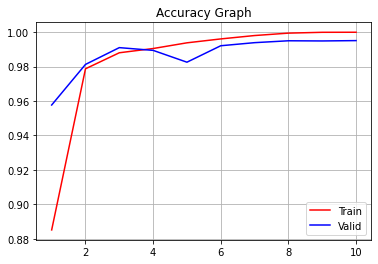


**************************************************



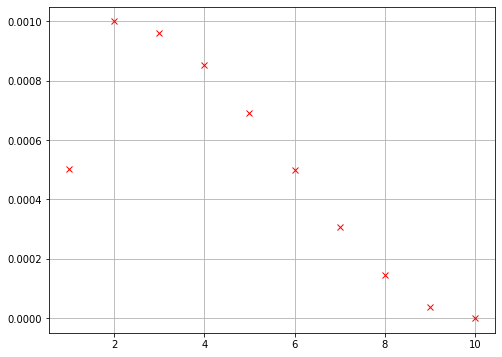


**************************************************


**************************************************

 ----- Seed 23 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.42382 | Valid Loss: 0.09376 | Train Accs: 0.88464 | Valid Accs: 0.97223 | Time: 20.84 seconds
Epoch: 2 | Train Loss: 0.06540 | Valid Loss: 0.04012 | Train Accs: 0.97986 | Valid Accs: 0.98746 | Time: 21.04 seconds
Epoch: 3 | Train Loss: 0.03891 | Valid Loss: 0.03677 | Train Accs: 0.98749 | Valid Accs: 0.98746 | Time: 20.48 seconds
Epoch: 4 | Train Loss: 0.02753 | Valid Loss: 0.03764 | Train Accs: 0.99144 | Valid Accs: 0.98965 | Time: 20.34 seconds
Epoch: 5 | Train Loss: 0.01957 | Valid Loss: 0.02234 | Train Accs: 0.99409 | Valid Accs: 0.99333 | Time: 20.99 seconds
Epoch: 6 | Train Loss: 0.01163 | Valid Loss: 0.02500 | Train Accs: 0.99617 | Valid Accs: 0.99273 | Time: 19.19 seconds
Epoch: 7 | Train Loss: 0.00736 | Valid 

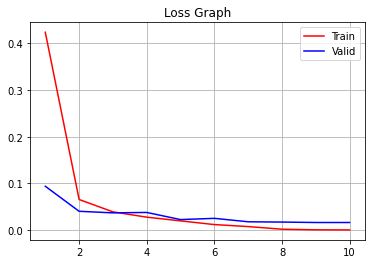


**************************************************



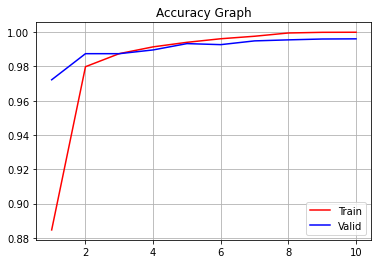


**************************************************



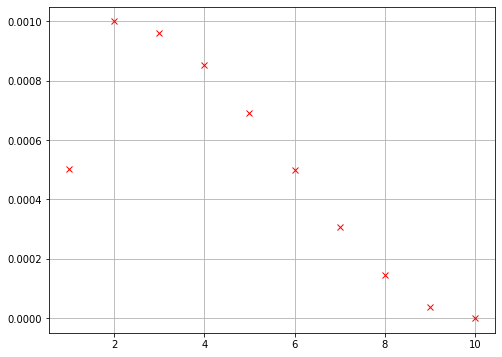


**************************************************


**************************************************

 ----- Seed 24 ----- 

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.41344 | Valid Loss: 0.16517 | Train Accs: 0.89014 | Valid Accs: 0.95034 | Time: 21.15 seconds
Epoch: 2 | Train Loss: 0.06886 | Valid Loss: 0.07003 | Train Accs: 0.97903 | Valid Accs: 0.97801 | Time: 20.73 seconds
Epoch: 3 | Train Loss: 0.03955 | Valid Loss: 0.03474 | Train Accs: 0.98779 | Valid Accs: 0.98895 | Time: 21.25 seconds
Epoch: 4 | Train Loss: 0.02905 | Valid Loss: 0.02551 | Train Accs: 0.99077 | Valid Accs: 0.99164 | Time: 21.05 seconds
Epoch: 5 | Train Loss: 0.01927 | Valid Loss: 0.02891 | Train Accs: 0.99442 | Valid Accs: 0.99094 | Time: 19.42 seconds
Epoch: 6 | Train Loss: 0.01285 | Valid Loss: 0.02867 | Train Accs: 0.99559 | Valid Accs: 0.99224 | Time: 20.16 seconds
Epoch: 7 | Train Loss: 0.00606 | Valid 

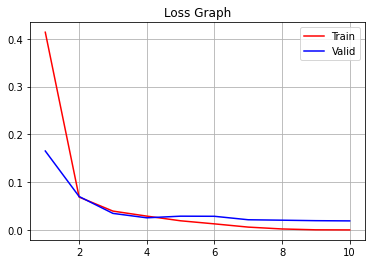


**************************************************



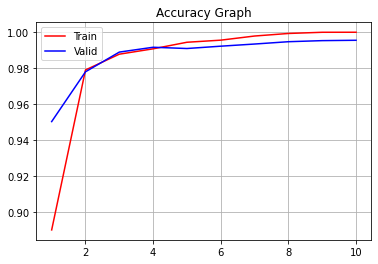


**************************************************



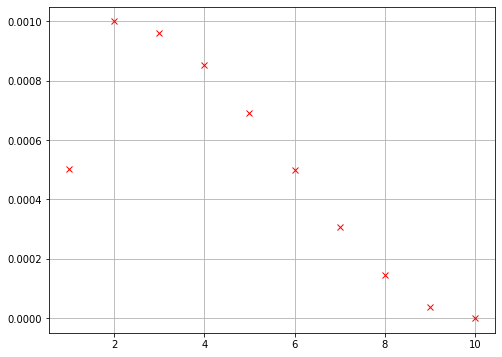


**************************************************



In [8]:
seeds: list = [i for i in range(25)]
BLEs: list = []
BAEs: list = []


for seed in seeds:
    breaker()
    print(f" ----- Seed {seed} ----- ")
    
    dataloaders = {
        "train" : DL(tr_data_setup, batch_size=cfg.batch_size, shuffle=True, generator=torch.manual_seed(seed)),
        "valid" : DL(ts_data_setup, batch_size=cfg.batch_size, shuffle=False),
    }

    cfg = CFG(
        epochs=10, 
        batch_size=64, 
        early_stopping=3,
        steps_per_epoch=len(dataloaders["train"])
    )

    torch.manual_seed(seed)
    model = Model(filter_sizes=[64, 128, 256], HL=[4096]).to(cfg.device)

    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)
    # optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)
    # optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd, momentum=0.9)

    scheduler_oclr = optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer, 
        max_lr=cfg.max_lr, 
        epochs=cfg.epochs, 
        steps_per_epoch=cfg.steps_per_epoch,
        pct_start=cfg.pct_start, 
        div_factor=cfg.div_factor, 
        final_div_factor=cfg.final_div_factor
    )

    # scheduler_rlrop = optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer=optimizer,
    #     patience=cfg.patience,
    #     eps=cfg.eps,
    #     verbose=True
    # )

    # scheduler_oclr = None
    scheduler_rlrop = None

    L, A, LR, BLE, BAE, _, _ = fit(
        model=model, 
        optimizer=optimizer, 
        scheduler_oclr=scheduler_oclr,
        scheduler_rlrop=scheduler_rlrop,
        epochs=cfg.epochs, 
        early_stopping_patience=cfg.early_stopping, 
        dataloaders=dataloaders,
        seed=seed,
        device=cfg.device,
        save_path=cfg.save_path,
        verbose=True
    )

    breaker()
    show_loss_graphs(L)
    breaker()
    show_accuracy_graphs(A)
    breaker()
    if scheduler_oclr:
        show_lr_graph(LR)
        breaker()
    
    BLEs.append(BLE)
    BAEs.append(BAE)

### **Best Model**

In [9]:
best_loss_index = BLEs.index(min(BLEs))
best_accs_index = BAEs.index(max(BAEs))

breaker()
print(f"Best Loss Model Seed     : {seeds[best_loss_index]}")
print(f"Best Accuracy Model Seed : {seeds[best_accs_index]}")
breaker()


**************************************************

Best Loss Model Seed     : 1
Best Accuracy Model Seed : 0

**************************************************

